# Fundamentals of Machine Learning - Horst R. Tomás

## Problem

You will work with an image dataset (see below for details). Your task is two-fold:

1. Build a baseline classification pipeline with a classic machine learning algorithm (i.e. not
based on a neural network) of your choosing, and estimate its classification error. There
should be efforts to improve this error as much as possible.

2. Build a convolutional neural network to classify the same dataset. There should be efforts
to improve its error over the baseline.

Both parts of the problem are mandatory and lacking one of them implies not passing the
course. A bonus point will be given if a pretrained model is implemented. This is in addition
to the hand-crafted convnet, and not in place of it.

##  Data

You will be working with the dataset associated to practice 03: faces dict.p, which you
can find in the guias/Datasets/ folder in the repo.

The dataset is composed by 400 images of 40 different people, each image consisting of
64x64 pixels, each quantized to 256 grey levels and converted to floating point values on the
interval [0, 1]. The target for this database is an integer from 0 to 39 indicating the identity
of the person pictured.

There are 10 different photos of the faces of 40 subjects and, in each photo, there
are properties that change (closed or open eyes, wearing or not wearing glasses, etc).
All the images were taken against a dark homogeneous background with the subjects
in an upright and frontal position. These are 64 x 64 pixel images (key ’images’ in the
dictionary object), and each image is flattened to a 1D vector of size 4096 (key ’data’ in
the dictionary object). The value of the element correspond to a grey level of that pixel.
The goal is to train a model that can predict the person at the image

In [ ]:
#Librerías
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import tensorflow as tf
import sklearn as sk
import pickle as pk

In [92]:
#Leeré el dataset de faces_dict.p
with open('faces_dict.p', 'rb') as f:
    faces_dict = pk.load(f)
print(faces_dict)
faces_dict.keys()

{'data': array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32), 'images': array([[[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083,
         0.3305785 , 0.30578512],
        [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083,
         0.338843  , 0.3140496 ],
        [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528,
         0.338843  , 0.29752067],
        ...,
        [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256,
         0.16528925, 0.17

dict_keys(['data', 'images', 'target'])

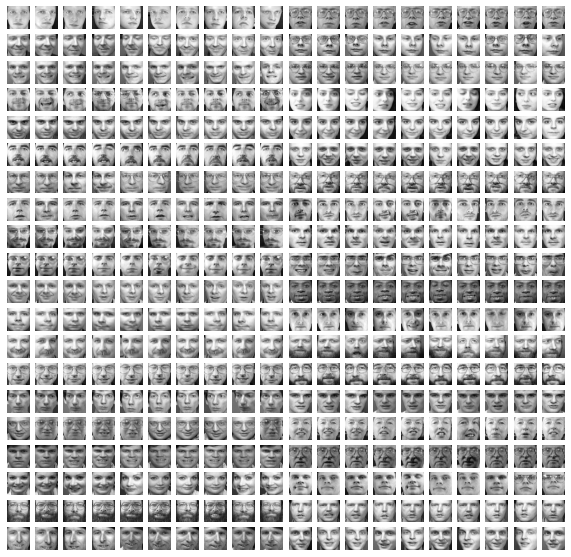

In [83]:
#Creo un array con las imágenes (numpy array)
faces2D = np.array(faces_dict['images'])

#Plotearé las imágenes del vector faces
fig, ax = plt.subplots(20, 20, figsize=(10, 10))
for i in range(20):
    for j in range(20):
        ax[i, j].imshow(faces2D[i*20+j], cmap='gray')
        ax[i, j].axis('off')
plt.show()

Observación de las imágenes: 

Algunos targets tienen anteojos en algunas fotos y no en otras. 

De una foto a otra suelen girar la cara, hacer gestos con los ojos y/o boca.

In [3]:
#En faces_dict tengo los target de cada imagen
targets = np.array(faces_dict['target'])

#Además, tengo las imágenes en  1D vector de tamaño 4096
faces1D = np.array(faces_dict['data'])

#Creo un dataframe con faces1D y con los targets
df = pd.DataFrame(faces1D, columns=['pixel'+str(i) for i in range(4096)])
#Última columna con el target
df['target'] = targets
print(df)

       pixel0    pixel1    pixel2    pixel3    pixel4    pixel5    pixel6  \
0    0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1    0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2    0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3    0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4    0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.400826  0.495868  0.570248  0.632231  0.648760  0.640496  0.661157   
396  0.367769  0.367769  0.351240  0.301653  0.247934  0.247934  0.367769   
397  0.500000  0.533058  0.607438  0.628099  0.657025  0.632231  0.657025   
398  0.214876  0.219008  0.219008  0.223140  0.210744  0.202479  0.276859   
399  0.516529  0.462810  0.280992  0.252066  0.247934  0.367769  0.574380   

       pixel7    pixel8    pixel9  ...  pixel4087  pixel4088  pixel4089  \


In [4]:
#Haré un split de 70% train, 20% validation, y 10% test
#Me quedarán 280 imágenes para el train, 80 para el validation y 40 para el test

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df.drop('target', axis=1), df['target'], test_size=80, random_state=42, stratify=df['target'])
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=40, random_state=42, stratify=y_train)
#Uso como argumento stratify para que el split sea proporcional a los targets

print("Tamaño de x_train: ",x_train.shape)
print("Tamaño de x_val: ",x_val.shape)
print("Tamaño de x_test: ",x_test.shape)

Tamaño de x_train:  (280, 4096)
Tamaño de x_val:  (80, 4096)
Tamaño de x_test:  (40, 4096)


In [10]:
#Entrenaré un modelo de clasificación clásica con pipeline, empezaré probando con random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])
rf.fit(x_train, y_train)
print("Accuracy del modelo en train: ",rf.score(x_train, y_train))
print("Accuracy del modelo en validation: ",rf.score(x_val, y_val))
print("Accuracy del modelo en test: ",rf.score(x_test, y_test))

Accuracy del modelo en train:  1.0
Accuracy del modelo en validation:  0.9375
Accuracy del modelo en test:  0.95


In [17]:
#Veré los recall del validation de random forest
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
y_pred_rf = rf.predict(x_val)
print(classification_report(y_val, y_pred_rf))
print("Recall de cada target: ",recall_score(y_val, y_pred_rf, average=None))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
          17       1.00    

In [21]:
#Veré los recall del test de random forest
from sklearn.metrics import recall_score
y_pred_rf = rf.predict(x_test)
print("Recall de cada target: ",recall_score(y_test, y_pred_rf, average=None))

Recall de cada target:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Nada mal, hay 4 targets que no están siendo predecidos correctamente en el validation, pero ninguno le errá al 100%.

En el test, hay dos que no se predijeron correctamente.

De todas formas seguiré probando con otros modelos.

In [62]:
#Ahora probaré entrenar con el modelo de Support Vector Machine
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
svm = Pipeline(steps=[('scaler', StandardScaler()), ('svm', LinearSVC(C=0.05))])
svm.fit(x_train, y_train)

print('Accuracy del train, LinearSVM: ', svm.score(x_train, y_train))
print('Accuracy del validation, LinearSVM: ', svm.score(x_val, y_val))
print('Accuracy del test, LinearSVM: ', svm.score(x_test, y_test))

Accuracy del train, LinearSVM:  1.0
Accuracy del validation, LinearSVM:  0.9625
Accuracy del test, LinearSVM:  0.975


A primera vista está dando mejor que random forest

In [19]:
#Veré los recall del validation de LinearSVM
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
y_pred = svm.predict(x_val)
print(classification_report(y_val, y_pred))
print("Recall de cada target: ",recall_score(y_val, y_pred, average=None))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       0.67      1.00      0.80         2
          17       1.00    

d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#Veré los recall del test de LinearSVM
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))
print("Recall de cada target: ",recall_score(y_test, y_pred, average=None))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00    

d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM está clasificando mejor que random forest.

In [15]:
#Haré un grid search con LinearSVM para ver que argumentos conviene utilizar
from sklearn.model_selection import GridSearchCV
# Valid parameters are: 
# ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter',
# 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'].

#Creo un diccionario con los parámetros que quiero probar
#C es la regularización, y penalty es el tipo de regularización
param_grid = {'svm__C': [0.1, 0.5, 1, 10, 50, 100, 150, 200], 'svm__penalty': ['l1', 'l2']}
grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ 

{'svm__C': 0.1, 'svm__penalty': 'l2'}
Pipeline(steps=[('scaler', StandardScaler()), ('svm', LinearSVC(C=0.1))])
0.9357142857142857


In [97]:
#Haré otro GridSearch más fino a partir de los parámetros que me dio el anterior
from sklearn.model_selection import GridSearchCV
param_grid = {'svm__C': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]}
grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'svm__C': 0.05}
Pipeline(steps=[('scaler', StandardScaler()), ('svm', LinearSVC(C=0.05))])
0.9428571428571428


d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [86]:
#Quiero ver que target decidió cuando falló la predicción en la validación
y_pred = svm.predict(x_val)
y_val_svm = np.array(y_val)
for i in range(len(y_pred)):
    if y_pred[i] != y_val_svm[i]:
        print('Valor real: ', y_val_svm[i], 'Valor predicho: ', y_pred[i])

Valor real:  4 Valor predicho:  35
Valor real:  0 Valor predicho:  28
Valor real:  0 Valor predicho:  16


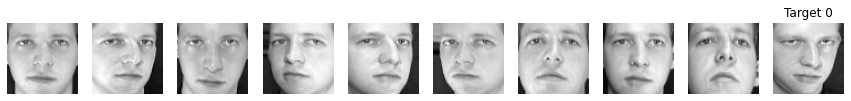

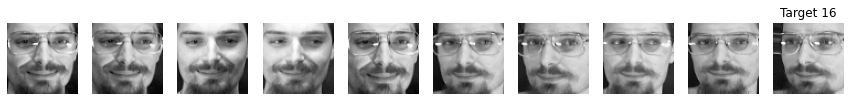

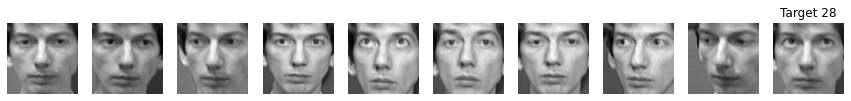

In [87]:
#Ploteando sólo los del target 0 de faces2D
mytarget = 0
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 0')
plt.show()

#Ploteando los del target 16 de faces2D
mytarget = 16
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 16')
plt.show()

#Ploteando los del target 28 de faces2D
mytarget = 28
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 28')
plt.show()

La verdad que no las veo muy parecidas a éstas personas.

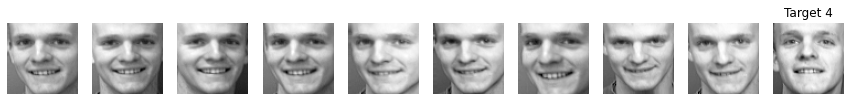

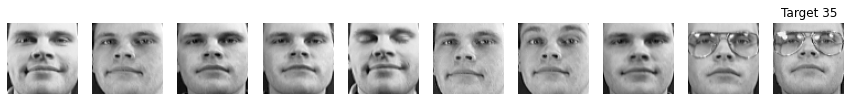

In [88]:
mytarget = 4
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 4')
plt.show()

mytarget = 35
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 35')
plt.show()

Algunas imágenes de los targets 4 y 35 están parecidas(boca, ojos, cejas), tiene algo de sentido que el modelo se confunda entre ellas.

In [90]:
#Ahora haré lo mismo para el test
#Quiero ver que target decidió cuando falló la predicción en el test
y_pred = svm.predict(x_test)
y_test_svm = np.array(y_test)
for i in range(len(y_pred)):
    if y_pred[i] != y_test_svm[i]:
        print('Valor real: ', y_test_svm[i], 'Valor predicho: ', y_pred[i])
        

Valor real:  12 Valor predicho:  0


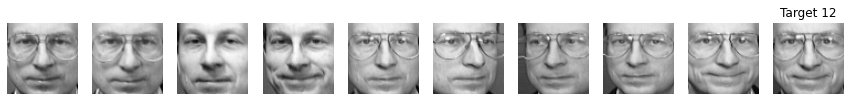

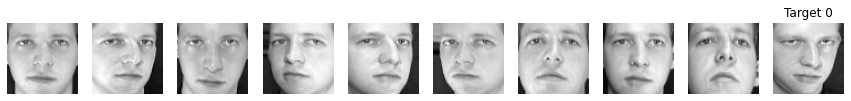

In [91]:
mytarget = 12
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 12')
plt.show()

mytarget = 0
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    ax[i].imshow(faces2D[i+mytarget*10], cmap='gray')
    ax[i].axis('off')
    plt.title('Target 0')
plt.show()

La forma de la nariz y las cejas son parecidas.

El target 0 está difícil de clasificar al parecer.

## Redes Neuronales

Build a convolutional neural network to classify the same dataset. There should be efforts
to improve its error over the baseline

In [38]:
from sklearn import model_selection
from tensorflow import keras as ks

#Debo acomodar mis datos para que sean compatibles con keras
x_train_redes = np.array(x_train)
x_val_redes = np.array(x_val)
x_test_redes = np.array(x_test)
y_train_redes = np.array(y_train)
y_val_redes = np.array(y_val)
y_test_redes = np.array(y_test)
#En primer la cantidad de imágenes, segundo y tercero el tamaño de las imágenes y cuarto es el canal(en éste caso 1 por ser blanco/negro)
x_train_redes = x_train_redes.reshape(x_train_redes.shape[0], 64, 64, 1)
x_test_redes = x_test_redes.reshape(x_test_redes.shape[0], 64, 64, 1)
x_val_redes = x_val_redes.reshape(x_val_redes.shape[0], 64, 64, 1)

redes_neuronales = tf.keras.models.Sequential()
#El número de filtros es 28, el tamaño del kernel es 3x3, el stride es 1x1(cuanto shiftea) y el input shape es el tamaño de la imagen
redes_neuronales.add(ks.layers.Conv2D(28,(3,3),strides=(1,1),input_shape=x_train_redes.shape[1:]))
#Rectified Linear Unit: La activación para no tener todo lineal. Si hay valores negativos los pone en 0
redes_neuronales.add(ks.layers.Activation("relu")) 
#Dropout es una técnica de regularización para evitar el overfitting, se apaga un porcentaje de las neuronas al azar en cada iteración
redes_neuronales.add(ks.layers.Dropout(0.05))
#MaxPooling es para reducir el tamaño de la imagen, se tomará el máximo de cada 2x2
redes_neuronales.add(ks.layers.MaxPooling2D((2,2)))

#Aplico una vez más lo mismo, pero ahora con un número mayor de filtros
redes_neuronales.add(ks.layers.Conv2D(56,(3,3),strides=(1,1)))
redes_neuronales.add(ks.layers.Activation("relu"))
redes_neuronales.add(ks.layers.Dropout(0.05))
redes_neuronales.add(ks.layers.MaxPooling2D((2,2)))

#Se aplana la imágen, es decir, se pasa de 2D a 1D
redes_neuronales.add(ks.layers.Flatten())
#Se aplica una capa densa de 128 neuronas, es decir, se conecta cada neurona de la capa anterior con cada neurona de la capa densa
redes_neuronales.add(ks.layers.Dense(128))
redes_neuronales.add(ks.layers.Activation('relu'))
redes_neuronales.add(ks.layers.Dropout(0.05)) 
redes_neuronales.add(ks.layers.Dense(40))

#Aplico la última capa de softmax que clasifica, mapeo de la función de activación
redes_neuronales.add(ks.layers.Activation('softmax'))
redes_neuronales.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ks.callbacks.ModelCheckpoint(filepath="training_1/cp.ckpt", save_weights_only=True,verbose=1)
redes_neuronales.fit(x_train_redes, y_train_redes, epochs=150, validation_data=(x_val_redes, y_val_redes), callbacks = [checkpoint])

Epoch 1/150
9/9 [==============================] - ETA: 0s - loss: 3.7640 - accuracy: 0.0250
Epoch 1: saving model to training_1\cp.ckpt
9/9 [==============================] - 3s 276ms/step - loss: 3.7640 - accuracy: 0.0250 - val_loss: 3.6825 - val_accuracy: 0.0500
Epoch 2/150
9/9 [==============================] - ETA: 0s - loss: 3.6783 - accuracy: 0.0500
Epoch 2: saving model to training_1\cp.ckpt
9/9 [==============================] - 3s 325ms/step - loss: 3.6783 - accuracy: 0.0500 - val_loss: 3.6656 - val_accuracy: 0.0750
Epoch 3/150
9/9 [==============================] - ETA: 0s - loss: 3.6463 - accuracy: 0.0393
Epoch 3: saving model to training_1\cp.ckpt
9/9 [==============================] - 2s 279ms/step - loss: 3.6463 - accuracy: 0.0393 - val_loss: 3.6214 - val_accuracy: 0.0500
Epoch 4/150
9/9 [==============================] - ETA: 0s - loss: 3.5763 - accuracy: 0.0536
Epoch 4: saving model to training_1\cp.ckpt
9/9 [==============================] - 3s 294ms/step - loss: 3.57

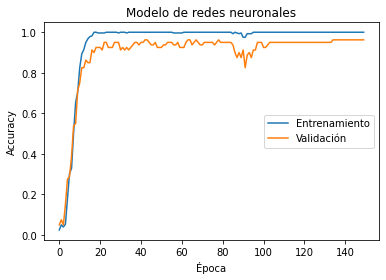

In [39]:
#Haré gráficas del accuracy del train y del validation en función de las épocas(epochs)
redes_neuronales.load_weights("training_1/cp.ckpt")
plt.plot(redes_neuronales.history.history['accuracy'])
plt.plot(redes_neuronales.history.history['val_accuracy'])
plt.title('Modelo de redes neuronales')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='right')

Me quedaré con el modelo que tiene mayor cantidad de épocas.

In [44]:
#Veré accuracy de modelo de redes neuronales con el mejor valor de época
#Veré que época es más conveniente utilizar
print('Accuracy del train de redes neuronales: ', redes_neuronales.evaluate(x_train_redes, y_train_redes)[1])
print("\n")
print('Accuracy del validation de redes neuronales: ', redes_neuronales.evaluate(x_val_redes, y_val_redes)[1])
print("\n")
print('Accuracy del test de redes neuronales: ', redes_neuronales.evaluate(x_test_redes, y_test_redes)[1])
print("\n")

9/9 [==============================] - 0s 33ms/step - loss: 7.3712e-05 - accuracy: 1.0000
Accuracy del train de redes neuronales:  1.0


3/3 [==============================] - 0s 21ms/step - loss: 0.1822 - accuracy: 0.9625
Accuracy del validation de redes neuronales:  0.9624999761581421


2/2 [==============================] - 0s 14ms/step - loss: 0.0124 - accuracy: 1.0000
Accuracy del test de redes neuronales:  1.0




Estaba dando 1 el accuracy del test pero 0,9625 el del validation:

No es confiable ésto. Puede que los casos patológicos hayan quedado en el train y en el validation, y justo los casos más sencillos en el test.

In [45]:
#Veré los recall
print("Validación:")
y_pred_val = redes_neuronales.predict(x_val_redes)
y_pred_val = np.argmax(y_pred_val, axis=1)
print(classification_report(y_val_redes, y_pred_val))

Validación:
3/3 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16     

In [46]:
print("Test:")
y_pred_test = redes_neuronales.predict(x_test_redes)
y_pred_test = np.argmax(y_pred_test, axis=1)
print(classification_report(y_test_redes, y_pred_test))

Test:
2/2 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00 

In [47]:
redes_neuronales.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 28)        280       
                                                                 
 activation_16 (Activation)  (None, 62, 62, 28)        0         
                                                                 
 dropout_12 (Dropout)        (None, 62, 62, 28)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 28)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 56)        14168     
                                                                 
 activation_17 (Activation)  (None, 29, 29, 56)        0         
                                                      

# Data Augmentation

Ésta es una manera de tener más datos, tergevisando de distintas maneras las imágenes y agregarlas al dataseet

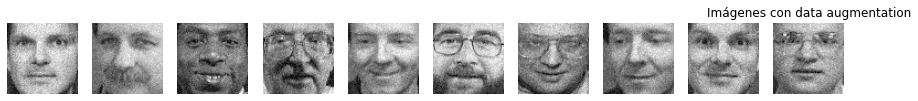

El tamaño de x_train_2 es:  (560, 4096)
El doble de lo que se tenía


In [48]:
#Les agregaré ruido gaussiano al x_train_2 y x_test_2
from skimage.util import random_noise
train = int(400*0.7)

x_train_np = np.array(x_train)
x_train_noise = np.zeros((train, 4096))
for i in range(train):
    x_train_noise[i] = random_noise(x_train_np[i], mode='gaussian', seed=None, clip=True, mean=0, var=0.002)
x_train_noise = x_train_noise.reshape(train, 64, 64)

#Ahora quiero espejar las imágenes con ruido 
x_train_2 = np.zeros((train, 64, 64))
for i in range(train):
    x_train_2[i] = x_train_noise[i][:, ::-1]
x_train_2 = x_train_2.reshape(train, 4096)

#Plotearé unas 10 imágenes para ver si se ve el ruido(se ajustó a var=0.002)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_2[i+9*10].reshape(64, 64), cmap='gray')
    plt.axis('off')
plt.title('Imágenes con data augmentation')
plt.show()
#Agregaré las imágenes con ruido y espejadas al x_train
x_train_2 = np.concatenate((x_train, x_train_2), axis=0)
#Agregaré los targets al y_train
y_train_2 = np.concatenate((y_train, y_train), axis=0)

print('El tamaño de x_train_2 es: ', x_train_2.shape)
print("El doble de lo que se tenía")

El tamaño de x_train_2 es:  (840, 4096)
El triple de lo que se tenía en un principio


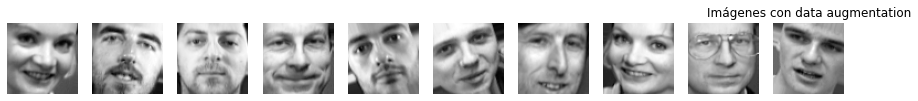

In [49]:
#Librería de keras para data augmentation
from keras.preprocessing.image import ImageDataGenerator
#Creo un objeto de ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20, #grados de rotación
        width_shift_range=0.01, #porcentaje de desplazamiento horizontal
        height_shift_range=0.01, #porcentaje de desplazamiento vertical
        shear_range=0.1, #porcentaje de desplazamiento en sentido diagonal
        zoom_range=0.0, #porcentaje de zoom
        horizontal_flip=True, #si se puede voltear horizontalmente
        fill_mode='nearest') #como se rellena los pixeles que se crean al rotar, desplazar, etc

#Aplico datagen a las imágenes del x_train
x_train_new = np.array(x_train)
train = int(400*0.7)
x_train_new = datagen.flow(x_train_new.reshape(train,64,64,1), batch_size=train, shuffle=False).next()

#Plotearé unas imágenes para ver como quedaron
fig, ax = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
        ax[i].imshow(x_train_new[i].reshape(64, 64), cmap='gray')
        ax[i].axis('off')
        plt.title('Imágenes con data augmentation')

#Agregaré las nuevas imágenes al x_train
x_train_new = x_train_new.reshape(train, 4096)
x_train_2 = np.concatenate((x_train_2, x_train_new), axis=0)
#Agregaré los targets al y_train
y_train_2 = np.concatenate((y_train_2, y_train), axis=0)

print('El tamaño de x_train_2 es: ', x_train_2.shape)
print("El triple de lo que se tenía en un principio")

## Entrenando la red neuronal con data augmentation

In [57]:
#Redes neuronales convolucionales con keras
from sklearn import model_selection
from tensorflow import keras as ks

x_train_redes_2 = np.array(x_train_2)
x_val_redes_2 = np.array(x_val)
x_test_redes_2 = np.array(x_test)
y_train_redes_2 = np.array(y_train_2)
y_val_redes_2 = np.array(y_val)
y_test_redes_2 = np.array(y_test)
x_train_redes_2 = x_train_redes_2.reshape(x_train_redes_2.shape[0], 64, 64, 1)
x_val_redes_2 = x_val_redes_2.reshape(x_val_redes_2.shape[0], 64, 64, 1)
x_test_redes_2 = x_test_redes_2.reshape(x_test_redes_2.shape[0], 64, 64, 1)

redes_neuronales_2 = tf.keras.models.Sequential()
redes_neuronales_2.add(ks.layers.Conv2D(28,(3,3),strides=(1,1),input_shape=x_train_redes_2.shape[1:]))
redes_neuronales_2.add(ks.layers.Activation("relu")) 
redes_neuronales_2.add(ks.layers.Dropout(0.05))
redes_neuronales_2.add(ks.layers.MaxPooling2D((2,2)))

redes_neuronales_2.add(ks.layers.Conv2D(56,(3,3),strides=(1,1)))
redes_neuronales_2.add(ks.layers.Activation("relu"))
redes_neuronales_2.add(ks.layers.Dropout(0.05))
redes_neuronales_2.add(ks.layers.MaxPooling2D((2,2)))

redes_neuronales_2.add(ks.layers.Flatten()) 
redes_neuronales_2.add(ks.layers.Dense(128))
redes_neuronales_2.add(ks.layers.Activation('relu'))
redes_neuronales_2.add(ks.layers.Dropout(0.05)) 
redes_neuronales_2.add(ks.layers.Dense(40))

redes_neuronales_2.add(ks.layers.Activation('softmax'))
redes_neuronales_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Quiero que mi modelo final sea el que obtuvo mayor val_accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
redes_neuronales_2.fit(x_train_redes_2, y_train_redes_2, epochs=120, validation_data=(x_val_redes_2, y_val_redes_2),
                                                                                            callbacks=[checkpoint])


Epoch 1/120
27/27 [==============================] - ETA: 0s - loss: 3.6977 - accuracy: 0.0476
Epoch 1: val_accuracy improved from -inf to 0.16250, saving model to best_model.h5
27/27 [==============================] - 6s 195ms/step - loss: 3.6977 - accuracy: 0.0476 - val_loss: 3.6766 - val_accuracy: 0.1625
Epoch 2/120
27/27 [==============================] - ETA: 0s - loss: 3.6306 - accuracy: 0.1083
Epoch 2: val_accuracy improved from 0.16250 to 0.22500, saving model to best_model.h5
27/27 [==============================] - 6s 205ms/step - loss: 3.6306 - accuracy: 0.1083 - val_loss: 3.5276 - val_accuracy: 0.2250
Epoch 3/120
27/27 [==============================] - ETA: 0s - loss: 3.2498 - accuracy: 0.2464
Epoch 3: val_accuracy improved from 0.22500 to 0.38750, saving model to best_model.h5
27/27 [==============================] - 5s 188ms/step - loss: 3.2498 - accuracy: 0.2464 - val_loss: 2.8690 - val_accuracy: 0.3875
Epoch 4/120
27/27 [==============================] - ETA: 0s - loss

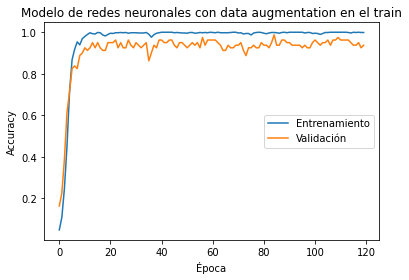

In [58]:
#Haré gráficas del accuracy del train y del validation en función de las épocas(epochs)
redes_neuronales_2.load_weights("best_model.h5")
plt.plot(redes_neuronales_2.history.history['accuracy'])
plt.plot(redes_neuronales_2.history.history['val_accuracy'])
plt.title('Modelo de redes neuronales con data augmentation en el train')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='right')

In [59]:
#Printearé el mejor accuracy del train y del validation que se obtuvo
print('El mejor accuracy del train es: ', max(redes_neuronales_2.history.history['accuracy']))
print('El mejor accuracy del validation es: ', max(redes_neuronales_2.history.history['val_accuracy']))
print('Con una época de: ', redes_neuronales_2.history.history['val_accuracy'].index(max(redes_neuronales_2.history.history['val_accuracy'])))

El mejor accuracy del train es:  1.0
El mejor accuracy del validation es:  0.987500011920929
Con una época de:  84


In [60]:
from sklearn.metrics import classification_report
#Veré accuracy de redes neuronales
print('Accuracy del train de redes neuronales 2: ', redes_neuronales_2.evaluate(x_train_redes_2, y_train_redes_2)[1])
print("\n")
print('Accuracy del validation de redes neuronales 2: ', redes_neuronales_2.evaluate(x_val_redes_2, y_val_redes_2)[1])
print("\n")
print('Accuracy del test de redes neuronales 2: ', redes_neuronales_2.evaluate(x_test_redes_2, y_test_redes_2)[1])
print("\n")

27/27 [==============================] - 1s 26ms/step - loss: 2.4662e-04 - accuracy: 1.0000
Accuracy del train de redes neuronales 2:  1.0


3/3 [==============================] - 0s 23ms/step - loss: 0.1872 - accuracy: 0.9875
Accuracy del validation de redes neuronales 2:  0.987500011920929


2/2 [==============================] - 0s 12ms/step - loss: 0.1800 - accuracy: 0.9500
Accuracy del test de redes neuronales 2:  0.949999988079071




Bien, éstos resultados son más comprensibles.

Mejoró el accuracy del validation en comparación al modelo de redes aplicado al dataseet en crudo

In [19]:
#Veré todos los recall del Validation
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
y_pred = redes_neuronales_2.predict(x_val_redes_2)
y_pred = np.argmax(y_pred, axis=1)
print("\nValidation del modelo de redes neuronales 2(con data augmentation):\n")
print('Recall de cada target: ', recall_score(y_val_redes_2, y_pred, average=None))
print(classification_report(y_val_redes_2, y_pred))

3/3 [==============================] - 0s 31ms/step

Validation del modelo de redes neuronales 2(con data augmentation):

Recall de cada target:  [1.  1.  1.  1.  0.5 1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  0.5
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  0.5]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       0.67      1.00      0.80         2
           8       0.67      1.00      0.80         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.0

In [20]:
#Veré todos los recall del Test
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
y_pred = redes_neuronales_2.predict(x_test_redes_2)
y_pred = np.argmax(y_pred, axis=1)
print("\nValidation del modelo de redes neuronales 2(con data augmentation):\n")
print('Recall de cada target: ', recall_score(y_test_redes_2, y_pred, average=None))
print(classification_report(y_test_redes_2, y_pred))

2/2 [==============================] - 0s 9ms/step

Validation del modelo de redes neuronales 2(con data augmentation):

Recall de cada target:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      

d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programas\Anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
redes_neuronales_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 28)        280       
                                                                 
 activation_4 (Activation)   (None, 62, 62, 28)        0         
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 28)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 28)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 56)        14168     
                                                                 
 activation_5 (Activation)   (None, 29, 29, 56)        0         
                                                      

El accuracy del validation es mejor en el modelo de redes neunorales con data augmentation que en el modelo de SVM.

Y el accuracy del test es mejor en el SVM que en el modelo de redes neuronales con data augmentation.

Sin embargo, por la simpleza que contempla SVM, cómo modelo final me quedaré con este.

No siempre deep learning es la respuesta...

# Modelo preentrenado

In [31]:
#Probaré con VGG16
from tensorflow.keras.applications import VGG16
modelo_preentrenado = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

x_train_redes_3 = np.repeat(x_train_redes, 3, axis=3)
x_val_redes_3 = np.repeat(x_val_redes, 3, axis=3)
x_test_redes_3 = np.repeat(x_test_redes, 3, axis=3)
y_train_redes_3 = np.array(y_train_redes)
y_val_redes_3 = np.array(y_val_redes)
y_test_redes_3 = np.array(y_test_redes)
#Ahora entreno el modelo preentrenado, con redes neuronales
redes_neuronales_3 = tf.keras.models.Sequential()
redes_neuronales_3.add(modelo_preentrenado)
redes_neuronales_3.add(ks.layers.Flatten())
redes_neuronales_3.add(ks.layers.Dense(128))
redes_neuronales_3.add(ks.layers.Activation('relu'))
redes_neuronales_3.add(ks.layers.Dropout(0.05))
redes_neuronales_3.add(ks.layers.Dense(40))
redes_neuronales_3.add(ks.layers.Activation('softmax'))
redes_neuronales_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = ks.callbacks.ModelCheckpoint(filepath="training_preentrenado/cp.ckpt", save_weights_only=True,verbose=1)
redes_neuronales_3.fit(x_train_redes_3, y_train_redes_3, epochs=50, validation_data=(x_val_redes_3, y_val_redes_3),
                                                                                            callbacks=[checkpoint])

#Veré accuracy de modelo preentrenado
print('Accuracy del train de modelo preentrenado: ', modelo_preentrenado.evaluate(x_train_redes_3, y_train_redes_3)[1])
print("\n")
print('Accuracy del validation de modelo preentrenado: ', modelo_preentrenado.evaluate(x_val_redes_3, y_val_redes_3)[1])
print("\n")
print('Accuracy del test de modelo preentrenado: ', modelo_preentrenado.evaluate(x_test_redes_3, y_test_redes_3)[1])
print("\n")

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.1685 - accuracy: 0.0107
Epoch 1: saving model to training_1\cp.ckpt
9/9 [==============================] - 39s 4s/step - loss: 5.1685 - accuracy: 0.0107 - val_loss: 3.7164 - val_accuracy: 0.0250
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 3.7202 - accuracy: 0.0393
Epoch 2: saving model to training_1\cp.ckpt
9/9 [==============================] - 43s 5s/step - loss: 3.7202 - accuracy: 0.0393 - val_loss: 3.6956 - val_accuracy: 0.0250
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.6958 - accuracy: 0.0107
Epoch 3: saving model to training_1\cp.ckpt
9/9 [==============================] - 41s 5s/step - loss: 3.6958 - accuracy: 0.0107 - val_loss: 3.6917 - val_accuracy: 0.0250
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 3.6954 - accuracy: 0.0214
Epoch 4: saving model to training_1\cp.ckpt
9/9 [==============================] - 41s 5s/step - loss: 3.6954 - accurac

KeyboardInterrupt: 

Corté el modelo porque no estaba mejorando el accuracy del validation, y mi cpu no da para tanto.